In [1]:
from tensorflow import keras

## IMDB 데이터셋

인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 50,000로 이루어진 데이터셋이다. 이 데이터셋은 훈련 데이터 25,000개와 테스트 데이터 25,000개로 뉘어 있고 각각 긍정 50%, 부정 50%로 구성되어 있다.

In [2]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 1s 0us/step


num_words=10000 매개변수는 훈련 데이터에서 가장 자주 나타나는 단어 1만개만 사용하겟다는 의미이다. 이렇게 하면 적절한 크기의 벡터 데이터를 얻을 수 있다.

변수 train_data와 test_data는 리뷰의 목록이다. 각 리뷰는 단어 인덱스의 리스트이고 train_labels와 test_labels는 부정을 나타내는 0과 긍정을 나타내는 1의 리스트이다.

In [3]:
train_data.shape

(25000,)

In [5]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
train_labels[0]

1

가장 자주 등장하는 단어 10,000개로 제한했기 때문에 단어 인덱스는 10,000을 넘지 않는다.

In [7]:
max([max(sequence) for sequence in train_data])

9999

이 리뷰 데이터 하나를 원래 영어 단어로 어떻게 바꿀까?

In [8]:
# word_index는 단어와 정수 인덱스를 매핑한 딕셔너리이다.
word_index = imdb.get_word_index()
# 정수 인덱스와 단어를 매핑하도록 뒤집는다.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 리뷰를 디코딩한다.
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺀다.
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1654784/1641221 [==============================] - 0s 0us/step


In [9]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## 데이터 준비

신경망에 숫자 리스트를 주입할 수는 없다. 리스트를 텐서로 바꾸는 두 가지 방법이 있다.
* 같은 길이가 되도록 리스트에 패딩을 추가하고 (samples, sequence_length) 크기의 정수 텐서로 변환한다. 그다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫번째 층으로 사용한다.
* 리스트를 원핫인코딩하여 0과 1의 벡터로 변환한다. 그 다음 부동 소수 벡터 데이터를 다룰 수 있는 Dense 층을 신경망의 첫번째 층으로 사용한다.  

여기서는 두 번째 방식을 사용하고 이해를 돕기 위해 직접 데이터를 원핫벡터로 만들겠다.

In [34]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # 크기가 (len(sequences), dimesion)이고 모든 원소가 0인 행렬을 만든다.
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # results[i]에서 특정 인덱스의 위치를 1로 만든다.
        
    return results

# 훈련 데이터를 벡터로 변환한다.
x_train = vectorize_sequences(train_data)
# 테스트 데이터를 벡터로 변환한다.
x_test = vectorize_sequences(test_data)

In [11]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

레이블은 쉽게 벡터로 바꿀 수 있다.

In [13]:
y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')

이제 신경망에 주입할 데이터가 준비되었다.

## 신경망 모델 만들기

입력 데이터가 벡터이고 레이블은 스칼라이다. 굉장히 간단한 문제이다. 이런 문제에 잘 작동하는 네트워크 종류는 relu 활성화 함수를 사용한 완전 연결 층을 그냥 쌓은 것이다.

다음은 이 신경망의 케라스 구현이다.

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2022-05-17 11:27:37.232199: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 11:27:38.765117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21332 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:06:00.0, compute capability: 7.5


마지막으로 손실함수와 옵티마이저를 선택해야 한다. 이진 분류 문제이고 신경망의 출력이 확률이기 때문에 binary_crossentropy 손실이 적합하다. 

In [15]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

이따금 옵티마이저의 매개변수를 바꾸거나 자신만의 손실 함수, 측정 함수를 전달해야 할 경우가 있다. 전자의 경우에는 옵티마이저 파이썬 클래스를 사용해 객체를 직접 만들어 optimizer 매개변수에 전달하면 된다.

In [18]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

후자의 경우는 loss와 metrics 매개변수에 함수 객체를 전달하면 된다.

In [19]:
from tensorflow.keras import losses
from tensorflow.keras import metrics

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

## 훈련 검증

훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 10,000의 샘플을 뗴어서 검증 세트를 만들어야 한다.

In [21]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

이제 모델을 512개 샘플씩 미니 배치를 만들어 20번의 에폭동안 훈련시킨다. 동시에 따로 떼어놓은 10,000개의 샘플에서 손실과 정확도를 측정할 것이다. 이렇게 하려면 validation_data 매개변수에 검증 데이터를 전달해야 한다.

In [22]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

2022-05-17 11:50:22.794358: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 600000000 exceeds 10% of free system memory.
2022-05-17 11:50:23.944390: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 600000000 exceeds 10% of free system memory.
2022-05-17 11:50:24.384319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
29/30 [============================>.] - ETA: 0s - loss: 0.5308 - binary_accuracy: 0.7839

2022-05-17 11:50:31.561697: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 400000000 exceeds 10% of free system memory.
2022-05-17 11:50:32.337343: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 400000000 exceeds 10% of free system memory.


30/30 [==============================] - 9s 214ms/step - loss: 0.5295 - binary_accuracy: 0.7849 - val_loss: 0.4103 - val_binary_accuracy: 0.8524
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.3247 - binary_accuracy: 0.8962 - val_loss: 0.3351 - val_binary_accuracy: 0.8633
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2369 - binary_accuracy: 0.9231 - val_loss: 0.2929 - val_binary_accuracy: 0.8838
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1867 - binary_accuracy: 0.9394 - val_loss: 0.2749 - val_binary_accuracy: 0.8913
Epoch 5/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1501 - binary_accuracy: 0.9534 - val_loss: 0.2772 - val_binary_accuracy: 0.8880
Epoch 6/20
30/30 [==============================] - 0s 17ms/step - loss: 0.1262 - binary_accuracy: 0.9605 - val_loss: 0.2893 - val_binary_accuracy: 0.8851
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1032 

model.fit() 메서드는 History 객체를 반환한다. 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 history 속성을 가지고 있다.

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

훈련과 검증 데이터에 대한 손실과 정확도를 시각화해보자.

In [25]:
import matplotlib.pyplot as plt

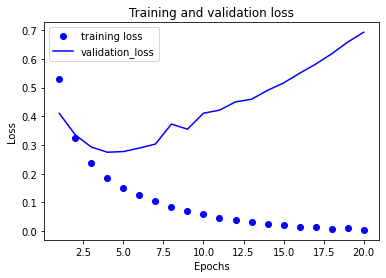

In [28]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

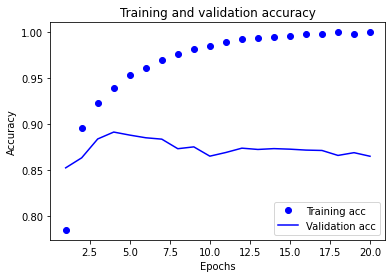

In [29]:
plt.clf()   # 그래프를 초기화
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

그래프에서 볼 수 있듯이 훈련 손실이 에폭마다 감소하고 훈련 정확도는 에폭마다 증가한다. 그러나 검증 손실과 정확도는 이와 같지 않다. 4번째 에폭에서 그래프가 역전되는 것 같다. 이는 과대적합이다.  
이런 경우에 과대적합을 방지하기 위해서 3번째 에폭 이후에 훈련을 중지할 수 있다. 

In [30]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

2022-05-17 12:11:17.076315: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1000000000 exceeds 10% of free system memory.


Epoch 1/4
49/49 [==============================] - 1s 9ms/step - loss: 0.4901 - accuracy: 0.8097
Epoch 2/4
49/49 [==============================] - 1s 10ms/step - loss: 0.2795 - accuracy: 0.9053
Epoch 3/4
49/49 [==============================] - 0s 9ms/step - loss: 0.2094 - accuracy: 0.9266
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2913 - accuracy: 0.8861


In [31]:
results

[0.2912551760673523, 0.8860800266265869]

## 훈련된 모델로 새로운 데이터에 대해 예측하기

predict 메서드를 사용해서 어떤 리뷰가 긍정일 확률을 예측할 수 있다.

In [32]:
model.predict(x_test)

array([[0.17933118],
       [0.9999808 ],
       [0.95122   ],
       ...,
       [0.15102334],
       [0.09883779],
       [0.57310164]], dtype=float32)